## Basic Libraries and Data Setup

In [1]:
import importlib

def import_or_install(package):
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        !pip install {package}

# List of packages to check and install if necessary
packages = [
    "stopwords",
    "flair",
    "nltk",
    "swifter",
    "wordcloud",
    "pyldavis",
    "scikit-learn",
    "imbalanced-learn"
]

for package in packages:
    import_or_install(package)


# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
sb.set()

reviewData = pd.read_csv('Datasets/reviews.csv')
reviewData.head()

stopwords is already installed.


D:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
D:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


flair is already installed.
nltk is already installed.
swifter is already installed.
wordcloud is already installed.
pyldavis is not installed. Installing...
scikit-learn is not installed. Installing...
imbalanced-learn is not installed. Installing...


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,Ruined my life.,1,0
1,10,Counter-Strike,This will be more of a ''my experience with th...,1,1
2,10,Counter-Strike,This game saved my virginity.,1,0
3,10,Counter-Strike,• Do you like original games? • Do you like ga...,1,0
4,10,Counter-Strike,"Easy to learn, hard to master.",1,1


In [2]:
reviewShape = reviewData.shape
print(reviewShape)
reviewtype = reviewData.dtypes
print(reviewtype)

(6417106, 5)
app_id           int64
app_name        object
review_text     object
review_score     int64
review_votes     int64
dtype: object


# Steam Game Review Sentiment Analysis

The ratings of a steam game are usually reflected in their reviews. In our analysis, we will analyze review comments to try and detect the hidden sentiments and factors that will determine the general sentiment of a game review.

### Set up Datasets
Since the dataset is so big, We will only take 1% of data to be used for our model and 5% for model validation and testing

In [3]:
num_rows = len(reviewData)
train_size = int(0.01 * num_rows)
validation_size = int(0.05 * num_rows)  

# Shuffle the dataset
shuffled_reviewData = reviewData.sample(frac=1, random_state=888).reset_index(drop=True)

# Extract the training and validation sets
train_data = shuffled_reviewData.iloc[:train_size].copy()
validation_data = shuffled_reviewData.iloc[train_size:train_size + validation_size].copy() # Selecting rows from train size to trainsize + validation size

# Print the sizes of each split
print("Training set size:", len(train_data))
print("Validation set size:", len(validation_data))
train_data.head()

Training set size: 64171
Validation set size: 320855


,app_id,app_name,review_text,review_score,review_votes
0,40800,Super Meat Boy,90/100 you won't regret buying this epic oldsk...,1,0
1,205100,Dishonored,-A guardsman and a thug engage in combat -Guar...,1,1
2,504370,Battlerite,Early Access Review,1,0
3,273110,Counter-Strike Nexon: Studio,This game is TERRIBLE. The graphics look like ...,-1,0
4,220200,Kerbal Space Program,This game has really taught me so much while s...,1,0


In [4]:
validation_data.head()

,app_id,app_name,review_text,review_score,review_votes
64171,40800,Super Meat Boy,Must get it its freaking awesome,1,0
64172,265210,Viscera Cleanup Detail: Santa's Rampage,Sooo...... when do we get the finished version...,1,0
64173,250620,Among the Sleep,"Decent game, short playthrough (one sitting) v...",1,0
64174,65300,Dustforce,I haven't played this game and know nothing ab...,1,0
64175,252490,Rust,Early Access Review,1,0


In [5]:
# Ensure review text are strings
train_data["review_text"] = train_data["review_text"].astype(str) 
validation_data["review_text"] = validation_data["review_text"].astype(str)

# Remove Early access reviews
train_data = train_data.drop(train_data[train_data.review_text == 'Early Access Review'].index)
validation_data = validation_data.drop(validation_data[validation_data.review_text == 'Early Access Review'].index)

# Remove Duplicates
train_data = train_data.drop_duplicates(keep='first')
validation_data = validation_data.drop_duplicates(keep='first')

### Analysis and Visualizations
#### Distribution between sentiments (positive and negative reviews)

In [6]:
sorted_data = train_data.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_text', ascending=False)
print(sorted_data)

   review_score  review_text
1             1        45309
0            -1         9975


#### Visualisation of distribution

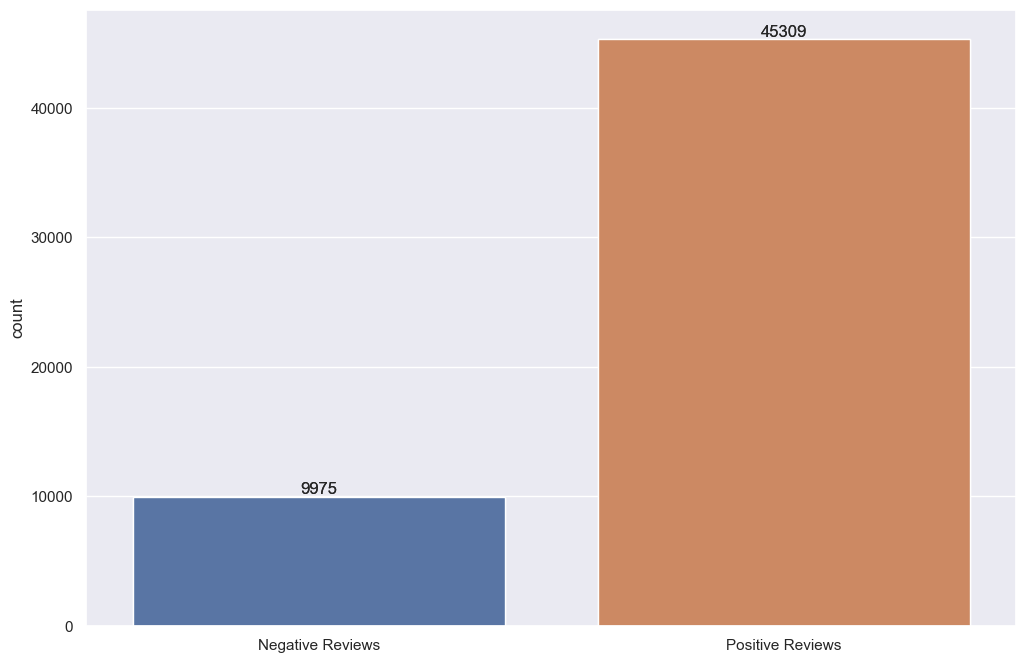

In [7]:
sb.set_theme(style='ticks')
sb.set(rc = {'figure.figsize':(12,8)})
sb.set_palette("deep")
sb.countplot(x='review_score',data= train_data)

# Show count labels on the bars
ax = sb.countplot(x='review_score', data=train_data)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Set x-axis labels
ax.set_xticklabels(['Negative Reviews', 'Positive Reviews'])
ax.set_xlabel(None)
plt.show()


We can see that there are more positive reviews than negative reviews, about 4 times more in this case.

### Distribution of length of reviews
Now let us see if positive or negative reviews have any difference in terms of length. We want to know if there is more in depth feedback captured in positive or negative reviews

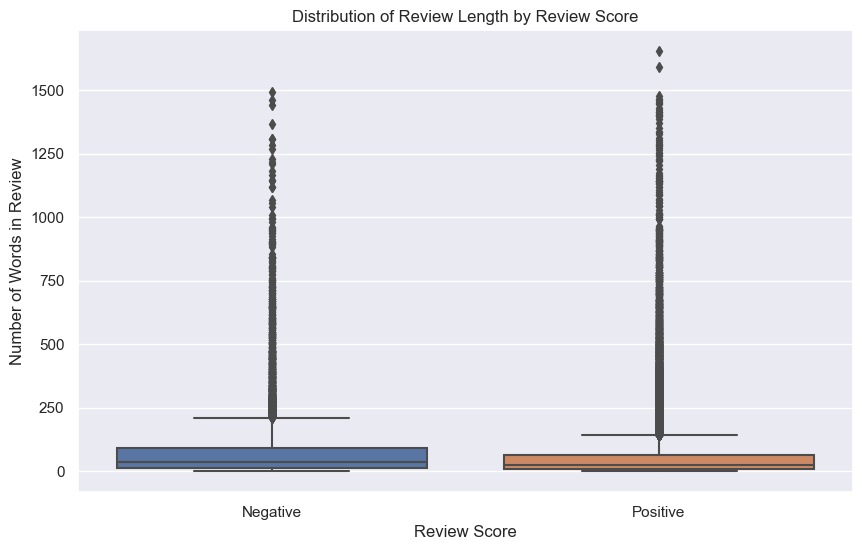

In [8]:
def count_words(text):
    # Convert the text to string and split it into words
    words = str(text).split()
    # Return the count of words
    return len(words)

RLength_data = train_data.copy()
# Apply the count_words function, we will create a new column which contains the number of words
RLength_data['Num_word_review'] = RLength_data['review_text'].apply(count_words)

plt.figure(figsize=(10, 6))
sb.boxplot(x='review_score', y='Num_word_review', data=RLength_data)
plt.title('Distribution of Review Length by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Number of Words in Review')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

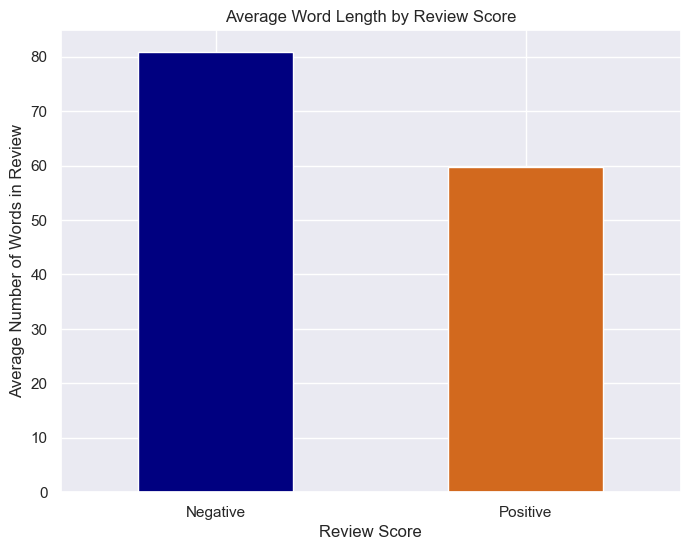

In [9]:
# Calculate average word length for negative and positive reviews
avg_word_length = RLength_data.groupby('review_score')['Num_word_review'].mean()

# Plot bar plot for average word length by review score
plt.figure(figsize=(8, 6))
avg_word_length.plot(kind='bar', color = ['navy','chocolate'])
plt.title('Average Word Length by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Average Number of Words in Review')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

We can observe that on average, negative reviews tend to have lengthier reviews, though there are outliers where positive reviews are just as long or even longer than negative reviews. Longer reviews may indicate more detailed opinions or experiences, while shorter reviews might convey quick reactions

### Identify and Analyse common topics in reviews 
We can find the most common words used and identify common traits of a good or bad game

#### Dataset cleaning and set up for wordcloud
We need to clean out the unnecessary punctuations, emojis, and numbers that would tell us not much in this case 

In [10]:
import re

def remove_misc(raw_text):
    # Remove hyperlinks and markup from raw text
    # Remove hyperlinks
    result = re.sub(r"<a[^>]*>(.+?)</a>", "Link.", raw_text)
    # Remove HTML entities
    result = re.sub(r"&[a-zA-Z]+;", "", result)
    # Remove HTML tags
    result = re.sub(r"<[^>]+>", " ", result)
    # Remove newline characters
    result = re.sub(r"\n", "", result)
    return result

def remove_num(text):
    # Remove numerical digits from the text
    return re.sub(r"\d+", "", text)

def removeEmoji(text):
    # Remove emojis from the text
    emoji_pattern = re.compile(
        r"[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def combine_spaces(text):
    # Replace multiple whitespaces with a single whitespace
    return re.sub(r'\s+', ' ', text)

def remove_symbols(text):
    # Remove non-alphanumeric characters, except for some specific punctuation
    return re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)

def remove_punctuation(text):
    # Remove common punctuation
    return re.sub(r"[?.,!;:\"']", '', text)

def clean(df, review_column):
    df[review_column] = df[review_column].apply(remove_misc).apply(removeEmoji).str.lower()
    df[review_column] = df[review_column].apply(remove_num).apply(remove_symbols).apply(remove_punctuation)
    return df


train_data = clean(train_data, 'review_text')




In [11]:
# Variables for positive and negative reviews
posReview = train_data[train_data['review_score']==1]
negReview = train_data[train_data['review_score']==-1]

#### Positive Review Wordcloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


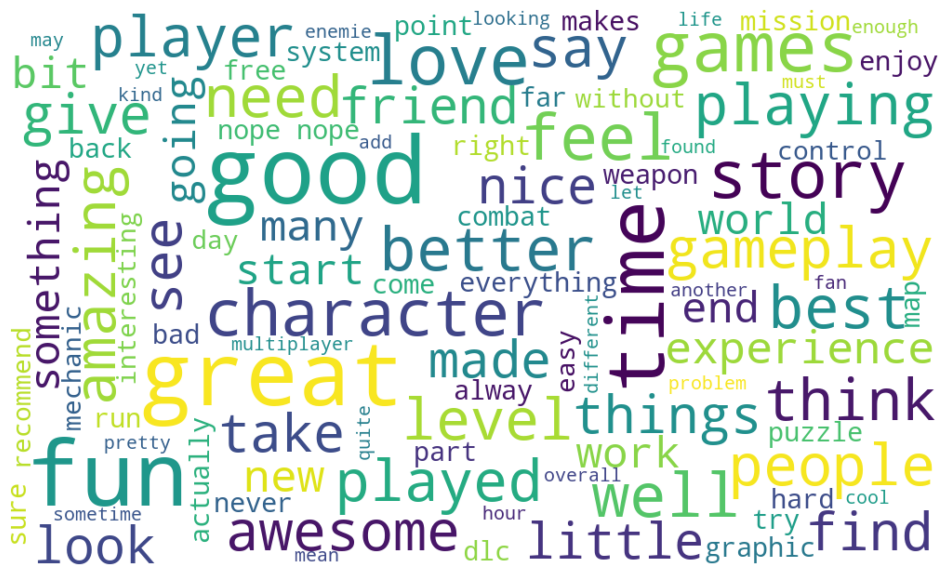

In [12]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')


# Stemmer
# snowball_stemmer = SnowballStemmer('english')
# Get the list of English stopwords
stop_words = set(stopwords.words('english'))
# Filter early access and other less helpful words commonly found
extra_stop_words = {'although', 'instead', 'seem', 'theres', 'maybe', 'got', 'that', 'though', 'early', 'access', 
                    'review', 'game', 'play', 'like', 'get', 'one', 'would', 'make', 'thing', 'go', 'lot', 'still',
                    'even', 'use', 'much', 'first', 'also', 'buy', 'way', 'ever', 'really', 'want', 'could', 'know', 
                    'every'}
stop_words.update(extra_stop_words)

reviewList = posReview.review_text.tolist()

# Empty List to store processed words
processed_words = []

# Iterate through each review
for review in reviewList:
    # Remove punctuation and convert to lowercase
    review = review.translate(str.maketrans('', '', string.punctuation)).lower()
    
    # Split the review into words
    words = review.split()
    #words = nltk.word_tokenize(review)
    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    # Add the processed words to the list
    processed_words.extend(filtered_words)

# Join the processed words into a single string
reviewText = ' '.join(processed_words)

wordcloud = WordCloud(
            background_color = 'white',
            min_word_length=3,
            colormap='viridis', 
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(reviewText)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

We can see that for postive sentiment review, the common sentiments and words used include 'good', 'great', 'best', 'experience' 'gameplay',,'feel', 'fun', 'voice acting' etc. 

This gives us a few potential characteristics or features of a game that are important in to player enjoyment of the game.  
Lets take a deeper look into which words are the most used

In [13]:
from collections import Counter

# Count the occurrences of each word
word_counts = Counter(processed_words)

# Get the top 10 most common words
top_words = word_counts.most_common(20)

# Create a DataFrame to display the top words
tempDF = pd.DataFrame(top_words, columns=['Common_words', 'count'])
tempDF.style.background_gradient(cmap='copper')


,Common_words,count
0,fun,11022
1,good,10934
2,great,9869
3,games,9092
4,time,7763
5,story,7757
6,best,6052
7,played,5649
8,well,5606
9,love,4693


We can see the order but to visualise how big the difference in the commonality of the words we can simply plot it out

<Axes: xlabel='count', ylabel='Common_words'>

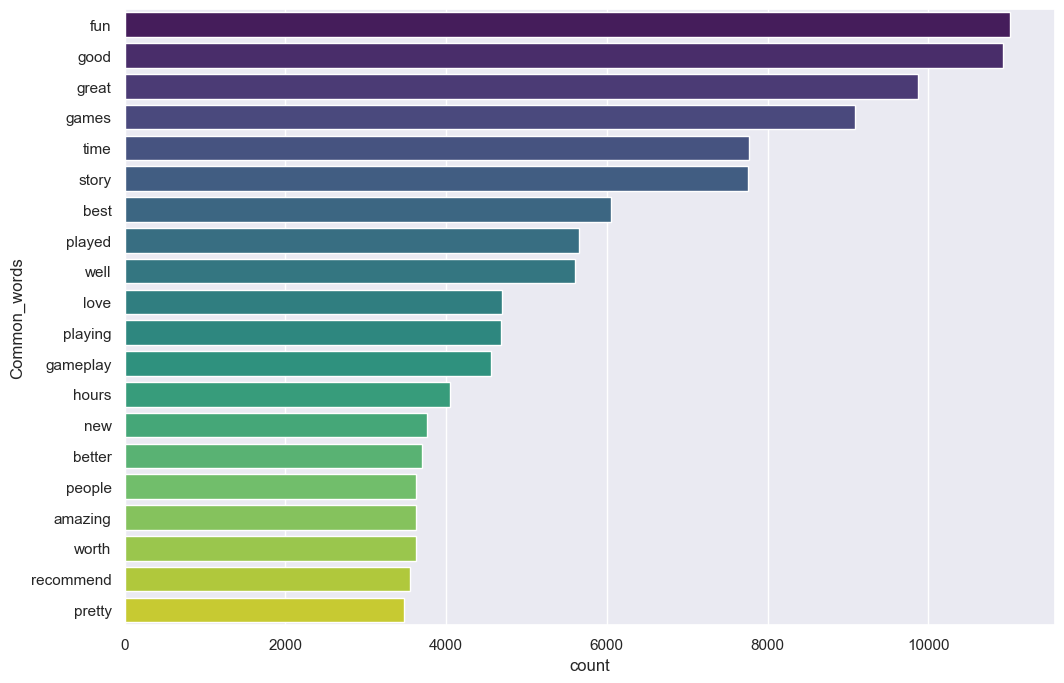

In [14]:
sb.set_theme(style="darkgrid")
sb.barplot(x="count", y="Common_words", data=tempDF, palette = 'viridis')

Let us see if we can find common topics using LDA processing

### LDA model

In Gensim, the LDA (Latent Dirichlet Allocation) model is implemented as part of the gensim.models.ldamodel module. The LDA model in Gensim allows you to perform topic modeling on a collection of texts.

In [15]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string

# Preprocess your text data
processed_text = [preprocess_string(doc) for doc in processed_words]

# Create a Dictionary representation of the documents
dictionary = Dictionary(processed_text)

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# Function to print the top words for each topic
def print_top_words(lda_model, num_words=20):
    for topic_id in range(lda_model.num_topics):
        words = lda_model.show_topic(topic_id, topn=num_words)
        topic_words = ", ".join([word for word, _ in words])
        print(f"Topic #{topic_id + 1}: {topic_words}")

# Print the top words for each topic
print("Topics found via LDA:")
print_top_words(lda_model)


Topics found via LDA:
Topic #1: good, great, feel, charact, better, run, complet, interest, actual, hard, old, long, person, steam, right, base, uniqu, platform, sale, like
Topic #2: plai, game, best, look, gameplai, world, bit, pretti, new, worth, enjoi, think, friend, try, player, come, weapon, music, easi, challeng
Topic #3: time, stori, recommend, end, click, peopl, get, experi, kill, thing, overal, bad, year, sure, expect, let, problem, take, multiplay, mechan
Topic #4: nope, love, level, graphic, make, littl, nice, puzzl, point, free, build, combat, mission, style, definit, mod, chang, option, art, rpg
Topic #5: fun, hour, start, amaz, differ, awesom, work, control, need, enemi, set, far, price, short, map, dai, life, fan, dlc, design


In [16]:
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.105741 -0.367173       1        1  20.068605
1     -0.080055  0.047947       2        1  20.036481
2      0.429953  0.008764       3        1  20.005122
4     -0.119261  0.003651       4        1  19.954467
0     -0.124897  0.306810       5        1  19.935325, topic_info=          Term          Freq         Total Category  logprob  loglift
3186      nope  14501.000000  14501.000000  Default  30.0000   30.000
63        good  11126.000000  11126.000000  Default  29.0000   29.000
48         fun  10751.000000  10751.000000  Default  28.0000   28.000
106       plai  10775.000000  10775.000000  Default  27.0000   27.000
41        time  10609.000000  10609.000000  Default  26.0000   26.000
...        ...           ...           ...      ...      ...      ...
1594      type   1229.191070   1230.008338   Topic5  -5.0942    1.612
530      gener   1219.143177   1219.960430   Topic5  -5.1024    1.612
551   progress   1212.091880   1212.909162   Topic5  -5.1082    1.612
581    content   1200.506673   1201.323909   Topic5  -5.1178    1.612
93      reason   1153.503314   1154.320578   Topic5  -5.1577    1.612

[180 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
453       3  0.999550  action
307       5  0.999499  actual
264       4  0.999146     add
241       3  0.999409  addict
345       4  0.999901    amaz
...     ...       ...     ...
43        4  0.999762    work
357       2  0.999904   world
46        2  0.999830   worth
1322      3  0.999810    year
513       5  0.999777   zombi

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

The larger the bubble the more prelevant the topic, all of the bubbles here are about equal in size
We will analyse the results along with results from negative reviews at the end.


Now we will do the same for negative reviews and compare the results

#### Negative Review Wordcloud

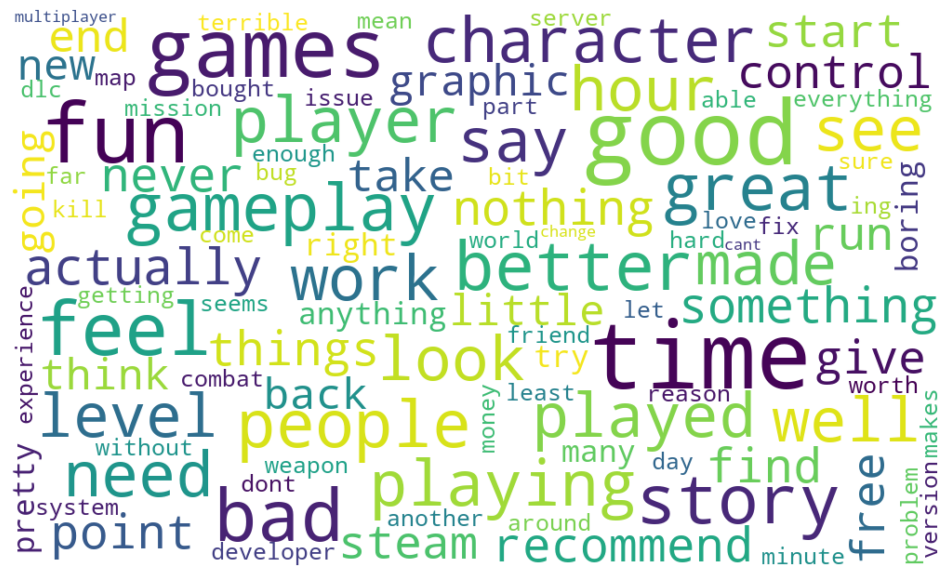

In [17]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

# Stemmer
snowball_stemmer = SnowballStemmer('english')
# Get the list of English stopwords
stop_words = set(stopwords.words('english'))
extra_stop_words = {'although', 'instead', 'seem', 'theres', 'maybe', 'got', 'that', 'though', 'early', 'access', 
                    'review', 'game', 'play', 'like', 'get', 'one', 'would', 'make', 'thing', 'go', 'lot', 'still',
                    'even', 'use', 'much', 'first', 'also', 'buy', 'way', 'ever', 'really', 'want', 'could', 'know', 
                    'every'}
stop_words.update(extra_stop_words)

reviewList = negReview.review_text.tolist()

# Empty List to store processed words
processed_words = []

# Iterate through each review
for review in reviewList:
    # Remove punctuation and convert to lowercase
    review = review.translate(str.maketrans('', '', string.punctuation)).lower()
    
    # Split the review into words
    words = review.split()
    #word_tokens = nltk.word_tokenize(review)
    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    # Add the processed words to the list
    processed_words.extend(filtered_words)

# Join the processed words into a single string
reviewText = ' '.join(processed_words)

wordcloud = WordCloud(
            background_color = 'white',
            min_word_length=3,
            colormap='viridis', 
            max_font_size = 100,
            max_words = 100,
            width = 1000,
            height = 600
            ).generate(reviewText)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

And we can see that for negative sentiment review, we can see some common words including 'nothing', 'boring', 'developer', 'issue', 'update', 'gameplay', 'level', etc 

We can see that there are some overlaps between words used between positive and negative reviews. Such as 'gameplay' and 'level' here. Perhaps how well these factors (the gameplay and level) are designed plays a huge factor in how players determine a good or bad game?

In [18]:
from collections import Counter

# Count the occurrences of each word
word_counts = Counter(processed_words)

# Get the top 10 most common words
top_words = word_counts.most_common(20)

# Create a DataFrame to display the top words
tempDF = pd.DataFrame(top_words, columns=['Common_words', 'count'])
tempDF.style.background_gradient(cmap='copper')


,Common_words,count
0,time,2324
1,good,2218
2,games,1916
3,fun,1650
4,bad,1402
5,story,1347
6,money,1246
7,playing,1239
8,better,1131
9,people,1075


<Axes: xlabel='count', ylabel='Common_words'>

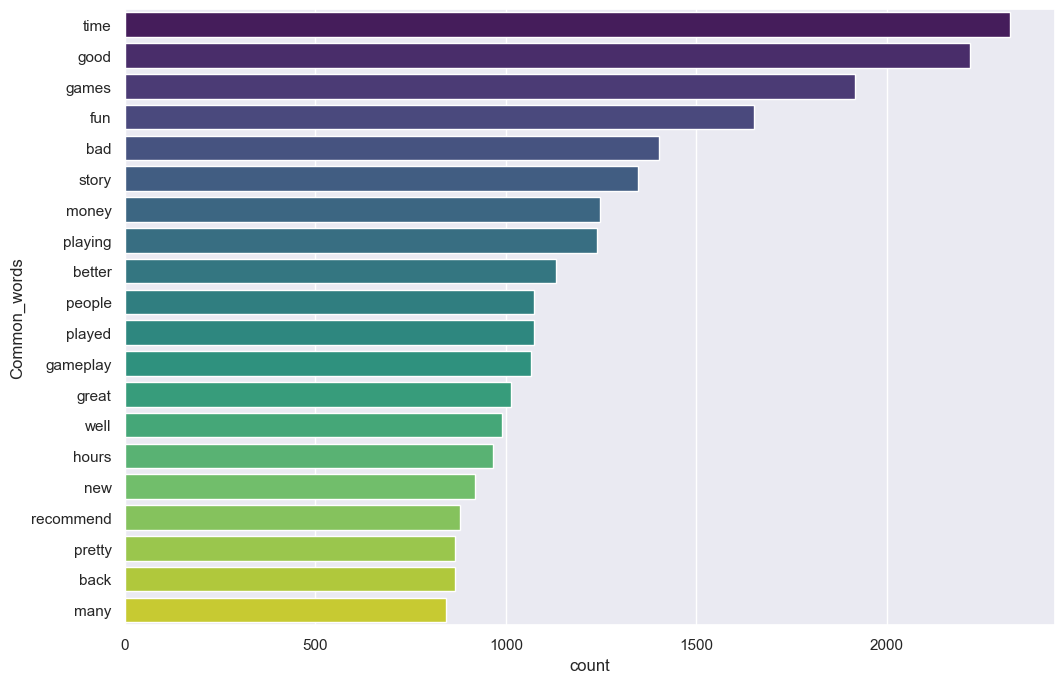

In [19]:
sb.set_theme(style="darkgrid")
sb.barplot(x="count", y="Common_words", data=tempDF, palette = 'viridis')

In [20]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string

# Preprocess your text data
processed_text = [preprocess_string(doc) for doc in processed_words]

# Create a Dictionary representation of the documents
dictionary = Dictionary(processed_text)

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)


# Function to print the top words for each topic
def print_top_words(lda_model, num_words=20):
    for topic_id in range(lda_model.num_topics):
        words = lda_model.show_topic(topic_id, topn=num_words)
        topic_words = ", ".join([word for word, _ in words])
        print(f"Topic #{topic_id + 1}: {topic_words}")

# Print the top words for each topic
print("Topics found via LDA:")
print_top_words(lda_model)


Topics found via LDA:
Topic #1: total, stori, better, get, crash, pai, right, set, dlc, save, wait, come, minut, releas, option, sound, finish, worst, basic, dai
Topic #2: work, final, good, feel, bad, try, control, run, actual, bore, graphic, level, complet, think, chang, mission, interest, steam, thing, world
Topic #3: time, plai, look, gameplai, point, littl, go, enemi, problem, turn, ing, bought, bit, real, year, long, abl, differ, map, fight
Topic #4: start, said, fun, charact, monei, new, great, end, develop, wast, version, love, far, combat, hard, second, attack, support, main, origin
Topic #5: warn, game, recommend, player, hour, peopl, need, fix, make, pretti, worth, bug, free, issu, dont, kill, enjoi, tell, mean, lack


In [21]:
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.007964  0.045892       1        1  20.094479
1     -0.034579  0.090463       2        1  20.014686
4     -0.304980 -0.260643       3        1  20.012888
0      0.359975 -0.199905       4        1  19.939115
3     -0.012451  0.324193       5        1  19.938833, topic_info=       Term         Freq        Total Category  logprob  loglift
61     work  6294.000000  6294.000000  Default  30.0000  30.0000
542   start  3479.000000  3479.000000  Default  29.0000  29.0000
97     time  3068.000000  3068.000000  Default  28.0000  28.0000
222   total  2909.000000  2909.000000  Default  27.0000  27.0000
422   final  2845.000000  2845.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
13     want   370.083441   370.910697   Topic5  -5.0179   1.6103
663  server   348.135431   348.962705   Topic5  -5.0790   1.6101
428     die   347.282181   348.109494   Topic5  -5.0815   1.6101
98     take   345.723632   346.550899   Topic5  -5.0860   1.6101
298   short   337.689717   338.516994   Topic5  -5.1095   1.6101

[180 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
51        1  0.998556      abl
314       1  0.999139  absolut
110       2  0.999461   actual
679       1  0.998783       ad
727       5  0.998360   attack
...     ...       ...      ...
61        2  0.999822     work
268       2  0.998761    world
516       4  0.999006    worst
389       3  0.998615    worth
500       1  0.997721     year

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

## Data Analysis
We have gotten the general sentiments and feedback from our wordcloud earlier, now we shall identify the common topics and factors that are relevant from our LDA model and intertopic distance map. Overlapping bubbles means there are common topics so we will give them more attention

In [22]:
import pandas as pd
from IPython.display import HTML

positive_common_factors = ['Fun', 'Hour', 'Control', 'Gameplay', 'Price', 'Map', 'DLC', 'Design', 'Items', 'World', 'Friend', 'Music', 'Challenge', 'Worth']
positive_less_common_factors = ['Character', 'Steam', 'Unique', 'Sale', 'Multiplayer', 'Graphics', 'Levels', 'Puzzle', 'Combat', 'Mission', 'Mod', 'Art', 'RPG', 'Shooter']

negative_common_factors = ['Work', 'Control', 'Feel', 'Graphics', 'Levels', 'World', 'Gameplay', 'Time', 'Enemies', 'Complete', 'Old']
negative_less_common_factors = ['Story', 'DLC', 'Weapon', 'Puzzle', 'Online', 'Progress', 'Character', 'Combat', 'Hard', 'Servers', 'Patch']

positive_dict = {'Common Factors': positive_common_factors,
                 'Less Common Factors': positive_less_common_factors}

negative_dict = {'Common Factors': negative_common_factors,
                 'Less Common Factors': negative_less_common_factors}

# Create DataFrames from dictionaries
positive_df = pd.DataFrame.from_dict(positive_dict, orient='index').transpose()
negative_df = pd.DataFrame.from_dict(negative_dict, orient='index').transpose()

# Function to apply color to DataFrame
def color_negative_red(val):
    color = 'red' if val.startswith('Negative') else 'green'
    return f'color: {color}'


# Define background colors
positive_common_color = '#a8e6cf'
positive_less_common_color = '#c7e5ff'
negative_common_color = '#ffc7ce'
negative_less_common_color = '#ffeb9b'
lighter_color = '#f0f0f0'

# Apply background colors based on factors
styled_positive_df = positive_df.style.applymap(lambda x: f'background-color: {positive_common_color}' if x in positive_common_factors else (f'background-color: {positive_less_common_color}' if x in positive_less_common_factors else f'background-color: {lighter_color}' if pd.isna(x) else ''), subset=pd.IndexSlice[:, :])
styled_negative_df = negative_df.style.applymap(lambda x: f'background-color: {negative_common_color}' if x in negative_common_factors else (f'background-color: {negative_less_common_color}' if x in negative_less_common_factors else f'background-color: {lighter_color}' if pd.isna(x) else ''), subset=pd.IndexSlice[:, :])

# Set the caption with HTML formatting
caption_positive = '<h3 style="text-align: center; color: #333;">Positive Reviews</h3>'
caption_negative = '<h3 style="text-align: center; color: #333;">Negative Reviews</h3>'

# Concatenate the captions with the styled DataFrames
styled_positive_with_caption = styled_positive_df.set_caption(caption_positive)
styled_negative_with_caption = styled_negative_df.set_caption(caption_negative)

# Wrap styled DataFrames with captions in div tags and apply styling
styled_positive_div = f"<div style='display:inline-block; text-align: center; margin-right: 50px;'>{styled_positive_with_caption._repr_html_()}</div>"
styled_negative_div = f"<div style='display:inline-block; text-align: center;'>{styled_negative_with_caption._repr_html_()}</div>"

# Display side by side
display(HTML(styled_positive_div + styled_negative_div))


,Common Factors,Less Common Factors
0,Fun,Character
1,Hour,Steam
2,Control,Unique
3,Gameplay,Sale
4,Price,Multiplayer
5,Map,Graphics
6,DLC,Levels
7,Design,Puzzle
8,Items,Combat
9,World,Mission


## Interpretation

### Factors Common to Both Positive and Negative Reviews:

- **Control:** The presence of "Control" in both positive and negative reviews suggests that while some players appreciate the game's control scheme, others may find it lacking or difficult to use. This indicates that control is a divisive aspect of the game experience, with some players enjoying it while others struggle with it.

- **Graphics:** Similarly, the inclusion of "Graphics" in both positive and negative reviews indicates that opinions on the game's visual aesthetics vary among players. While some players praise the graphics for their quality and immersion, others may criticize them for being underwhelming or outdated. This suggests that graphics play a significant role in shaping players' perceptions of the game.

- **Levels:** The mention of "Levels" in both positive and negative reviews suggests that level design is another contentious aspect of the game. While some players may appreciate the variety and complexity of the levels, others may find them repetitive or poorly designed. This indicates that level design can impact player enjoyment and satisfaction.

- **World:** The inclusion of "World" in both positive and negative reviews indicates that the game's setting and environment are subject to differing opinions among players. While some players may praise the game for its immersive world-building and lore, others may criticize it for feeling generic or uninspired. This suggests that the game's world is an important aspect that influences player experiences.

- **Gameplay:** "Gameplay" appearing in both positive and negative reviews suggests that players have mixed opinions about the mechanics and interactions within the game. While some players may enjoy the gameplay for its depth and complexity, others may find it tedious or uninteresting. This indicates that gameplay mechanics play a crucial role in shaping player perceptions and enjoyment.

- **Time:** The mention of "Time" in both positive and negative reviews suggests that players have differing experiences regarding the time investment required to enjoy the game fully. While some players may appreciate the game's longevity and replay value, others may feel that it is overly time-consuming or lacks pacing. This indicates that the time commitment required by the game is a factor that influences player satisfaction.

Analyzing factors common to both positive and negative reviews allows game developers to understand the diverse perspectives of players and identify areas for improvement. By addressing issues raised by players while also capitalizing on strengths highlighted in positive reviews, developers can work towards creating a more enjoyable and engaging gaming experience for all players.


### Recommendations

Based on the factors identified in both positive and negative reviews, the following recommendations are suggested:

- **Address Control and Graphics Issues:** Given that control and graphics are common concerns in negative reviews, prioritizing improvements in these areas can enhance the overall gaming experience.
  
- **Focus on Level Design and Gameplay:** Pay attention to level design and gameplay mechanics to ensure they are engaging, balanced, and enjoyable for players.
  
- **Optimize Game Performance:** Improve game optimization to reduce loading times, enhance frame rates, and minimize technical issues that detract from gameplay.
  
- **Provide Meaningful Content Updates:** Consider offering downloadable content (DLC) or updates that introduce new maps, items, challenges, and features to keep players engaged and satisfied.
  
- **Enhance Community Features:** Facilitate multiplayer experiences, foster player interaction, and support community-building initiatives to enhance player engagement and retention.
  
- **Improve Storytelling and Progression:** Enhance the game's narrative elements, character development, and overall storytelling to immerse players in the game world and provide a compelling gaming experience.



## Creating Review Text Classifier Model
Classification models, such as machine learning classifiers, automate the process of sentiment analysis by predicting the sentiment (positive, negative) of reviews based on their textual content. We will create a model to identify whether a review is positive or negative based on the review text


After identifying topics using Latent Dirichlet Allocation (LDA), we've gained insights into the underlying themes present in the Steam reviews. However, while LDA provides a high-level overview of the topics discussed, it doesn't capture the sentiment or emotions expressed within these topics. Therefore, creating a review text classifier model becomes essential to delve deeper into understanding the sentiment associated with each topic. 

By automating the process of sentiment analysis and predicting whether a review is positive or negative based on its textual content, we can complement the insights gained from LDA. This classifier allows us to discern the overall sentiment trends within each topic, enabling us to identify not only areas of satisfaction but also potential concerns or areas for improvement. 



#### Create a pipeline

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english",max_features=4000)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier()),
    ])

# Set x and y variables
x = train_data['review_text']
y = train_data['review_score']
Counter(y)

Counter({1: 45309, -1: 9975})

#### Tokenizing and Model training, we will use random forest as our classifier model

In [24]:
from sklearn.model_selection import train_test_split
# 80-20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = 0.20)

# Train the model
text_classifier = clf.fit(x_train,y_train)

# Predict the model on test data
model_predictions = text_classifier.predict(x_test)
np.unique(model_predictions) # we expect to see [-1, 1] as the output, indicating the two classes

array([-1,  1], dtype=int64)

#### Evaluate the Model Performance

Classification Accuracy: 0.8504115040245998
True Positive Rate Train Set: 0.9769086288807867
False Positive Rate Train Set: 0.7203389830508474
F1-Score: 0.6593237978232225
ROC-AUC 0.6282848229149696


<Axes: >

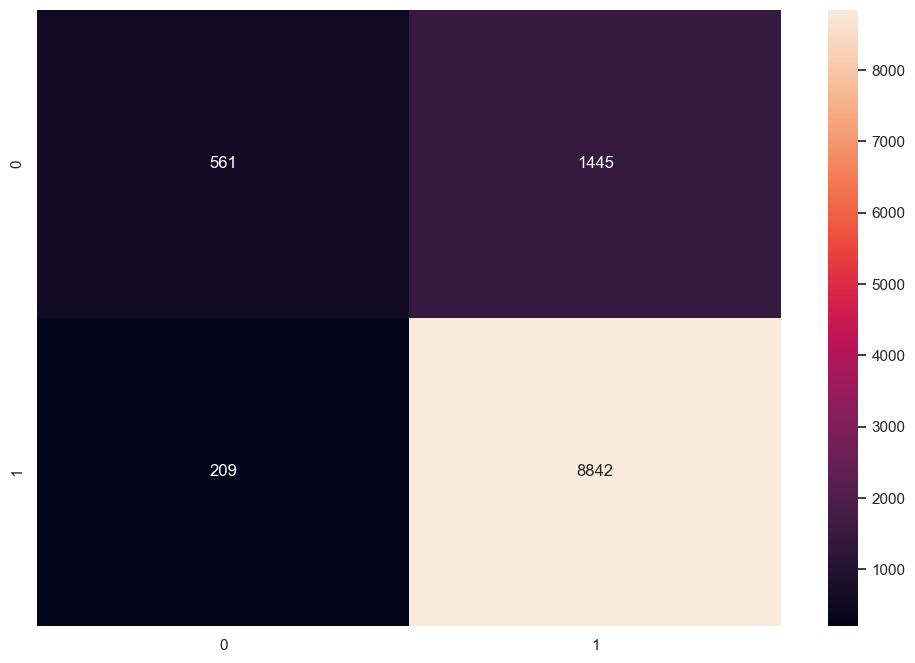

In [25]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

def printMetrics(y_test, model_predictions):
    # Setting up Confusion matrix and its data calc
    cm = confusion_matrix(y_test, model_predictions)

    # True Positive Rate
    tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])

    # False Positive Rate
    fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])

    # Accuracy Rate
    accuracy = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]) 

    # Check the Goodness of Fit
    print("Classification Accuracy:", accuracy)
    print("True Positive Rate Train Set:", tpr)
    print("False Positive Rate Train Set:", fpr)
    print('F1-Score: {}'.format(f1_score(y_test, model_predictions, average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_test, model_predictions)))

printMetrics(y_test, model_predictions)
sb.heatmap(confusion_matrix(y_test, model_predictions),annot=True, fmt='')

Our metrics shows relatively good performance in terms of accuracy and true positive rate. However, the relatively high false positive rate and moderate ROC-AUC score suggest that there is room for improvement. Probably due to the imbalance in positive and negative reviews as we saw earlier. Our F1-score reinforces this notion and shows that our model is still not that good at predicting negative classes. 

#### Model Validation
We will see how our model performs on a larger dataset, using the 10% of overall data we set up at the start

Classification Accuracy: 0.8573980207579049
True Positive Rate Train Set: 0.9777394087044562
False Positive Rate Train Set: 0.6966827603429618
F1-Score: 0.6749965454329495
ROC-AUC 0.6405283241807471


<Axes: >

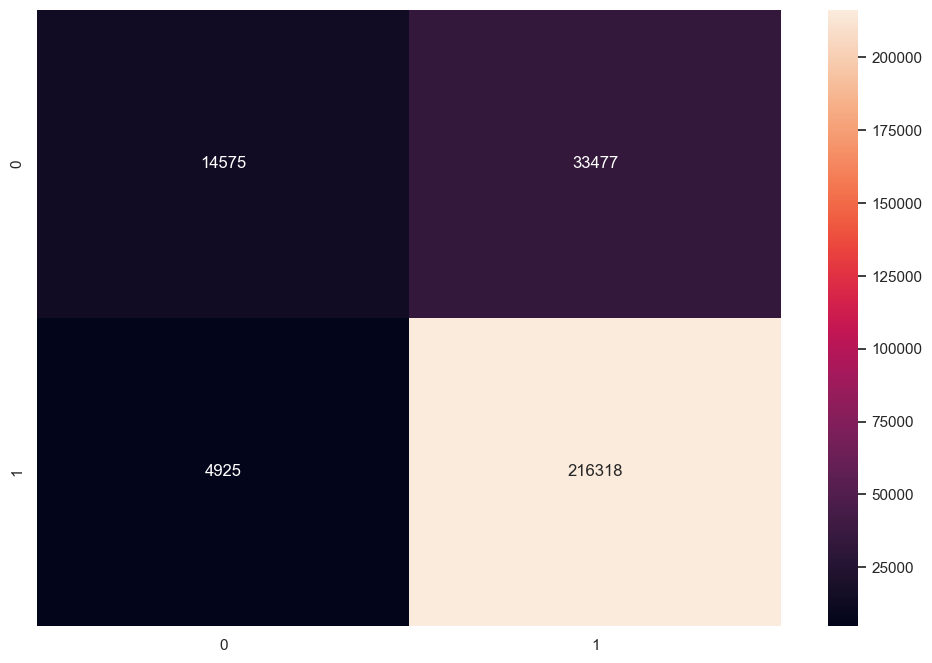

In [26]:
x_validation = validation_data['review_text']
y_validation = validation_data['review_score']
y_validation_pred = text_classifier.predict(x_validation)

printMetrics(y_validation, y_validation_pred)
sb.heatmap(confusion_matrix(y_validation, y_validation_pred), annot=True, fmt='')

Both models demonstrate reasonably good performance across various metrics, but there are still many opportunities for improvement, especially in terms of distinguishing between positive and negative sentiment classes (indicated by the ROC-AUC scores). Additionally, considering the potential for class imbalance, further analysis and potential use of imbalance handling techniques could be explored to enhance model performance further.

## Imbalanced data handling
We will use oversampling and undersampling method to handle our imbalanced data.

### Data preparation

In [27]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

# Strategies
s1 = {-1:40000}
s2 = {1:40000}

vect = CountVectorizer(stop_words= "english",max_features=3000)
tfidf = TfidfTransformer()
over = SMOTE(sampling_strategy=s1)
under = RandomUnderSampler(sampling_strategy=s2)
model = RandomForestClassifier()

X = train_data['review_text'].values
Y = train_data['review_score'].values
Counter(Y)

Counter({1: 45309, -1: 9975})

In [28]:
trf = vect.fit(X)
X = trf.transform(X)
steps = [('over', over), ('under', under)]
pipeline = PL(steps=steps)

# combine oversampling and undersampling techniques to balance the class distribution in the dataset.
X_resampled, Y_resampled = pipeline.fit_resample(X, Y)

counter_new = Counter(Y_resampled)
print("Proportion after oversampling and undersampling: \n",counter_new)

Proportion after oversampling and undersampling: 
 Counter({-1: 40000, 1: 40000})


Now we have a balanced sample of data on both X and Y, we will now train a model using the resampled data and evaluate its results on our original data to compare any difference in performance

In [29]:
# Resampled data 
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, random_state = 42, test_size = 0.20)

# Original data, We prepare our original data (before oversampling and undersampling) as our evaluation data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, test_size = 0.20)

#### Run Pipeline and train model

Classification Accuracy: 0.9205028488740165
True Positive Rate Train Set: 0.9258645453541046
False Positive Rate Train Set: 0.1036889332003988
F1-Score: 0.8768713310177011
ROC-AUC 0.9110878060768528


<Axes: >

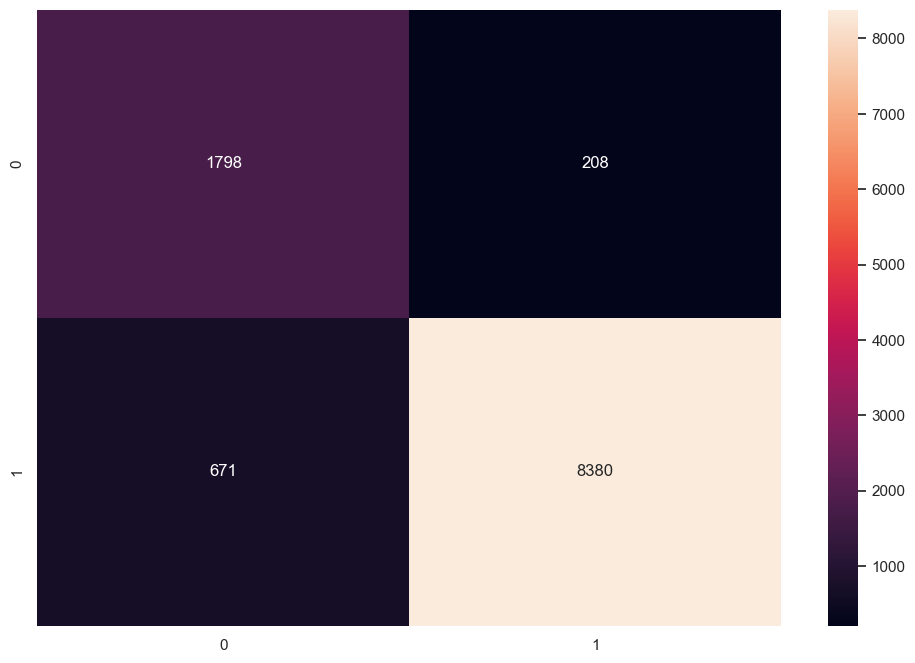

In [30]:
pipeline_new = Pipeline([
    ('tfidf', tfidf),
    ('model', model),
    ])

text_classifier_new = pipeline_new.fit(X_train, Y_train)

# Trained model on new data, now we evaluate on original data
predictions_new = text_classifier_new.predict(x_test)

# Confusion matrix
printMetrics(y_test,predictions_new)
sb.heatmap(confusion_matrix(y_test,predictions_new),annot=True,fmt='')

Our model after training it on oversampling and undersampling data showed great improvements. With classification accuracy of 92% and F1-Score of 0.87.
We also have ROC-AUC score of 0.91. So there is a high chance that the our text classifier model will be able to distinguish the positive sentiment class values from the negative sentiment class values.